<a href="https://colab.research.google.com/github/giulicrenna/data_science/blob/main/Copia_de_Clase_17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ¿Cómo podemos controlar el creciente número de accidentes en Nueva York?

---



In [ ]:
import json
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy

## Introduccion

**Contexto empresarial.** La ciudad de Nueva York ha experimentado un aumento en el número de accidentes en las carreteras de la ciudad. Quieren saber si el número de accidentes ha aumentado en las últimas semanas. Para todos los accidentes reportados, han recopilado detalles para cada accidente y han estado manteniendo registros durante el último año y medio (desde enero de 2018 hasta agosto de 2019).

La ciudad te ha contratado para que construyas visualizaciones que les ayuden a identificar patrones en accidentes, lo que les ayudaría a tomar acciones preventivas para reducir la cantidad de accidentes en el futuro. Tienen ciertos parámetros como municipio, hora del día, motivo del accidente, etc. De los que se preocupan y de los que les gustaría obtener información específica.

**Problema comercial.** Su tarea es formatear los datos proporcionados y proporcionar visualizaciones que respondan las preguntas específicas que tiene el cliente, que se mencionan a continuación.

**Contexto analítico.** Se le proporciona un archivo CSV (almacenado en la carpeta ```datos``` ya creada) que contiene detalles sobre cada accidente, como fecha, hora, ubicación del accidente, motivo del accidente, tipos de vehículos involucrados, recuento de lesiones y muertes, etc. El delimitador en el archivo CSV dado es `;` en lugar del predeterminado `,`. Realizará las siguientes tareas con los datos:

1. Extraiga datos adicionales del municipio almacenados en un archivo JSON
2. Leer, transformar y preparar datos para su visualización
3. Realizar análisis y construir visualizaciones de los datos para identificar patrones en el conjunto de datos.
        
El cliente tiene un conjunto específico de preguntas a las que le gustaría obtener respuestas. Deberá proporcionar visualizaciones para acompañar estos:

1. ¿Cómo ha fluctuado el número de accidentes durante el último año y medio? ¿Han aumentado con el tiempo?
2. Para un día en particular, ¿durante qué horas es más probable que ocurran accidentes?
3. ¿Hay más accidentes entre semana que durante los fines de semana?
4. ¿Cuál es la proporción de recuento de accidentes por área por municipio? ¿Qué distritos tienen un número desproporcionadamente grande de accidentes para su tamaño?
5. Para cada municipio, ¿durante qué horas es más probable que ocurran accidentes?
6. ¿Cuáles son las 5 principales causas de accidentes en la ciudad?
7. ¿Qué tipos de vehículos están más involucrados en accidentes por municipio?
8. ¿Qué tipos de vehículos están más involucrados en las muertes?

## Obteniendo los datos relevantes

El cliente ha solicitado un análisis de la relación accidentes-área de los distritos. Los datos del municipio se almacenan en un archivo JSON en la carpeta ```datos```.

### Pregunta (5 min):

Utilice la función ```json.load()``` para cargar el archivo ```borough_data.json``` como diccionario.

In [ ]:
from google.colab import drive
import os
drive.mount('/content/gdrive')
# Establecer ruta de acceso en dr
import os
print(os.getcwd())
os.chdir("/content/gdrive/My Drive")

Mounted at /content/gdrive
/content


**Respuesta.** 

In [ ]:
with open('borough_data.json') as f:
    borough_data=json.load(f)
    
borough_data

{'brooklyn': {'area': 70.82, 'name': 'brooklyn', 'population': 2648771.0},
 'manhattan': {'area': 22.83, 'name': 'manhattan', 'population': 1664727.0},
 'queens': {'area': 108.53, 'name': 'queens', 'population': 2358582.0},
 'staten island': {'area': 58.37,
  'name': 'staten island',
  'population': 479458.0},
 'the bronx': {'area': 42.1, 'name': 'the bronx', 'population': 1471160.0}}

### Pregunta (5 min):
De manera similar, use la función pandas ```read_csv()``` para cargar el archivo ```accidentes.csv``` como un DataFrame. Nombra este DataFrame ```df```.


**Answer.** 

In [ ]:
with open('accidents.csv') as f:
    df=pd.read_csv(f, delimiter=';')
type(df)

pandas.core.frame.DataFrame

In [ ]:
df=pd.read_csv('accidents.csv',delimiter=";")
type(df)

pandas.core.frame.DataFrame

## Overview de la data

Analizemos las columnas presentes en el data frame

In [ ]:
df.head(5)

,DATE,TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,ON STREET NAME,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,09/26/2018,12:12,BRONX,10454.0,40.808987,-73.911316,NaN,0,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,3988123,Sedan,NaN,NaN,NaN,NaN
1,09/25/2018,16:30,BROOKLYN,11236.0,40.636005,-73.912510,FLATLANDS AVENUE,1,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,3987962,Sedan,NaN,NaN,NaN,NaN
2,08/22/2019,19:30,QUEENS,11101.0,40.755490,-73.939530,NaN,0,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,4193132,Sedan,NaN,NaN,NaN,NaN
3,09/23/2018,13:10,QUEENS,11367.0,NaN,NaN,MAIN STREET,0,0,1,0,0,0,Driver Inattention/Distraction,Unspecified,NaN,NaN,NaN,3985962,Bike,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
4,08/20/2019,22:40,BRONX,10468.0,40.868336,-73.901270,NaN,0,0,0,0,1,0,View Obstructed/Limited,Unspecified,NaN,NaN,NaN,4192111,Sedan,Sedan,NaN,NaN,NaN


In [ ]:
df.columns

Index(['DATE', 'TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE',
       'ON STREET NAME', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5'],
      dtype='object')

Tenemos las siguientes columnas

1. **BOROUGH**: el municipio en el que ocurrió el accidente
2. **COLLISION_ID**: un identificador único para esta colisión
3. **CONTRIBUTING FACTOR VEHICLE (1, 2, 3, 4, 5)**: Motivos del accidente
4. **CROSS STREET NAME**: Calle transversal más cercana al lugar del accidente
5. **DATE**: Fecha del accidente
6. **TIME**: Hora del accidente
7. **LATITUDE**: Latitud del accidente
8. **LONGITUDE**: Longitud del accidente
9. **NUMBER OF (CYCLISTS, MOTORISTS, PEDESTRIANS) INJURED**: Lesión por categoría
10. **NUMBER OF (CYCLISTS, MOTORISTS, PEDESTRIANS) DEATHS**: Categoría muerte sabia
11. **ON STREET NAME**: Calle donde ocurrió el accidente
13. **VEHICLE TYPE CODE(1, 2, 3, 4, 5)**: Tipos de vehículos involucrados en el accidente
14. **ZIP CODE**: código postal del lugar del accidente

## Respondiendo las preguntas del cliente 

### Ejercicio 1 :

Agrupe los datos disponibles mensualmente y genere un line plot de accidentes a lo largo del tiempo. ¿Ha aumentado el número de accidentes durante el último año y medio?

**Sugerencia**: Puede encontrar útiles las funciones de pandas ```to_datetime ()``` y ```dt.to_period ()```.

**Answer.** 

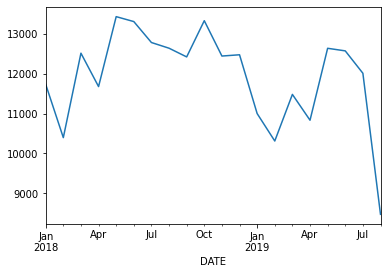

In [ ]:
df['DATE']=pd.to_datetime(df['DATE']) # Formato datetime python 
monthly_accidents =df.groupby(df['DATE'].dt.to_period('M')).size()
monthly_accidents.plot.line()

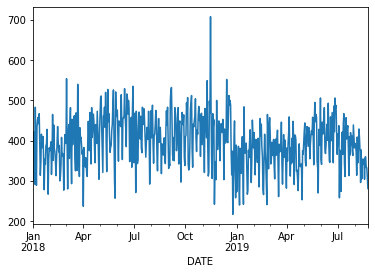

In [ ]:
#df['DATE']=pd.to_datetime(df['DATE'])
#monthly_accidents = df.groupby(df['DATE'].dt.to_period('M')).size()
#monthly_accidents.plot.line()

monthly_accidents1 = df.groupby(df['DATE'].dt.to_period('D')).size()
monthly_accidents1.plot.line()


In [ ]:
type(monthly_accidents)

pandas.core.series.Series

In [ ]:
max(df['DATE']) 

Timestamp('2019-08-24 00:00:00')

El gráfico de líneas que trazamos muestra claramente que no hay una tendencia alcista obvia en los accidentes a lo largo del tiempo.

### Ejercicio 2

De la gráfica anterior, ¿qué meses parecen tener el menor número de accidentes? ¿Cuáles crees que son las razones detrás de esto?

**Respuesta.** 

Notamos que agosto de 2019 es el mes con el menor número de accidentes, pero esto probablemente se deba al hecho de que no hay un registro completo para este mes: ```max(df['DATE']) = Timestamp('2019-08-24 00:00:00') ```. Es decir, falta toda la última semana de datos.

Sin tener en cuenta este mes, la menor cantidad de accidentes parece ocurrir en febrero. Este es el mes del año con las temperaturas más bajas y las condiciones de la carretera pueden complicarse un poco. Por lo tanto, las personas pueden preferir usar el transporte público y evitar salir tanto como sea posible debido al clima frío. Esto contrasta con el verano, donde las personas tienden a salir y pueden ocurrir más accidentes.

### Ejercicio 3 (30 min):
¿Cómo varía el número de accidentes a lo largo de un solo día? Cree una nueva columna `HOUR` basada en los datos de la columna `TIME`, luego trace un gráfico de barras de la distribución por hora a lo largo del día.

**Sugerencia:** Puede encontrar útil la función ```dt.hour```.

Text(0, 0.5, 'Total de accidentes')

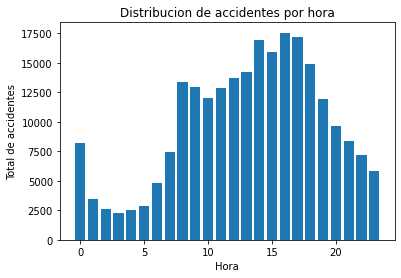

In [ ]:
df['TIME']=pd.to_datetime(df['TIME'])
df['HOUR'] = df['TIME'].dt.hour
hourly_accidents =df.groupby('HOUR').size()
hourly_accidents.index
hourly_accidents.values
plt.bar(hourly_accidents.index,hourly_accidents.values)
plt.title('Distribucion de accidentes por hora')
plt.xlabel('Hora')
plt.ylabel('Total de accidentes')

Text(0, 0.5, 'Total de accidentes')

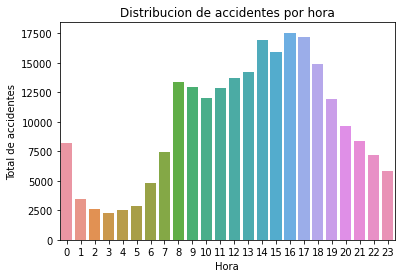

In [ ]:
sns.barplot(x=hourly_accidents.index, y=hourly_accidents.values)
plt.title('Distribucion de accidentes por hora')
plt.xlabel('Hora')
plt.ylabel('Total de accidentes')

A partir de esto, vemos que ocurren más accidentes en la tarde (2 - 6 PM) que en otros momentos del día.

### Ejercicio 4 :

¿Cómo varía el número de accidentes en una sola semana? Trace un gráfico de barras basado en el recuento de accidentes por día de la semana.

**Sugerencia:** Puede encontrar útil la función ```dt.weekday```.

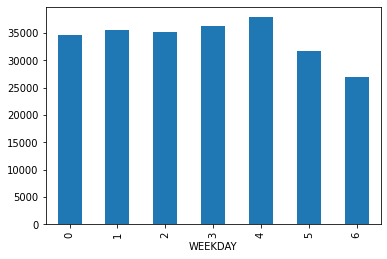

In [ ]:
df['WEEKDAY'] = df['DATE'].dt.weekday
weekday_accidents=df.groupby('WEEKDAY').size()
weekday_accidents.plot.bar()

Hay relativamente menos accidentes los fines de semana que entre semana.

### Ejercicio 5:

Trace una gráfica de barras del número total de accidentes en cada municipio, así como uno de los accidentes por milla cuadrada por municipio. ¿Qué puedes concluir?

**Sugerencia:** Es posible que desee actualizar algunas de las claves en el diccionario del municipio para que coincidan con los nombres en el marco de datos.

In [ ]:
df.groupby('BOROUGH').size()

BOROUGH
BRONX            37709
BROOKLYN         76253
MANHATTAN        48749
QUEENS           67120
STATEN ISLAND     8691
dtype: int64

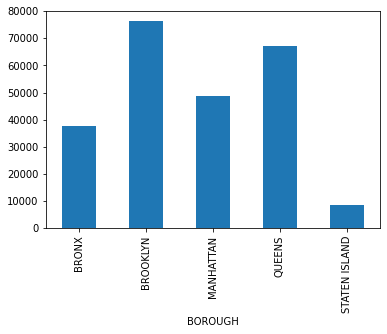

In [ ]:
boroughs = df.groupby('BOROUGH').size()
boroughs.plot.bar()

In [ ]:
borough_data

{'brooklyn': {'area': 70.82, 'name': 'brooklyn', 'population': 2648771.0},
 'manhattan': {'area': 22.83, 'name': 'manhattan', 'population': 1664727.0},
 'queens': {'area': 108.53, 'name': 'queens', 'population': 2358582.0},
 'staten island': {'area': 58.37,
  'name': 'staten island',
  'population': 479458.0},
 'the bronx': {'area': 42.1, 'name': 'the bronx', 'population': 1471160.0}}

Podemos ver que Brooklyn y Queens tienen un número muy alto de accidentes en relación con los otros tres condados. Pero, ¿qué tal por milla cuadrada?

In [ ]:
# Update keys in borough data
print(borough_data.keys())
print(df['BOROUGH'].unique())

# Since there are differences in the text used in the data and Wikipedia data, let's update it
borough_data['bronx'] = borough_data.pop('the bronx')


dict_keys(['the bronx', 'brooklyn', 'manhattan', 'queens', 'staten island'])
['BRONX' 'BROOKLYN' 'QUEENS' 'MANHATTAN' 'STATEN ISLAND']


In [ ]:
borough_frame = pd.DataFrame(boroughs)
borough_frame.columns = ['count']
borough_frame['borough'] = borough_frame.index
borough_frame['accidents_per_sq_mi'] = borough_frame.apply(lambda x: x['count']/borough_data[x['borough'].lower()]['area'], axis=1)
borough_frame

,count,borough,accidents_per_sq_mi
BOROUGH,,,
BRONX,37709,BRONX,895.700713
BROOKLYN,76253,BROOKLYN,1076.715617
MANHATTAN,48749,MANHATTAN,2135.304424
QUEENS,67120,QUEENS,618.446512
STATEN ISLAND,8691,STATEN ISLAND,148.894980


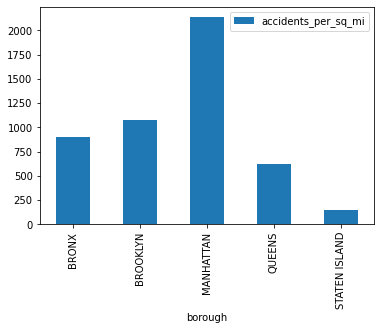

In [ ]:
borough_frame.plot.bar(x='borough', y='accidents_per_sq_mi')

Al mirar el parámetro `accident_per_sq_mi`, Manhattan encabeza la lista por un amplio margen. Esto muestra claramente que aunque Brooklyn y Queens tienen más accidentes totales, Manhattan tiene una concentración mucho mayor de accidentes.

### Ejercicio 6 :

¿Qué horas tienen más accidentes en cada municipio? Trace un gráfico de barras para cada municipio que muestre el número de accidentes por cada hora del día.

**Sugerencia:** Puede usar ```sns.FacetGrid``` para crear una cuadrícula de parcelas con los datos por hora de cada municipio.

In [ ]:
df.groupby(['BOROUGH', 'HOUR']).size()

BOROUGH        HOUR
BRONX          0       1329
               1        529
               2        402
               3        361
               4        418
                       ... 
STATEN ISLAND  19       415
               20       367
               21       268
               22       224
               23       174
Length: 120, dtype: int64

In [ ]:
df1 = pd.DataFrame({'count': df.groupby(['BOROUGH', 'HOUR']).size()})
df1
df1 = df1.reset_index()
df1.head(30)

,BOROUGH,HOUR,count
0,BRONX,0,1329
1,BRONX,1,529
2,BRONX,2,402
3,BRONX,3,361
4,BRONX,4,418
5,BRONX,5,508
6,BRONX,6,835
7,BRONX,7,1406
8,BRONX,8,2341
9,BRONX,9,2162


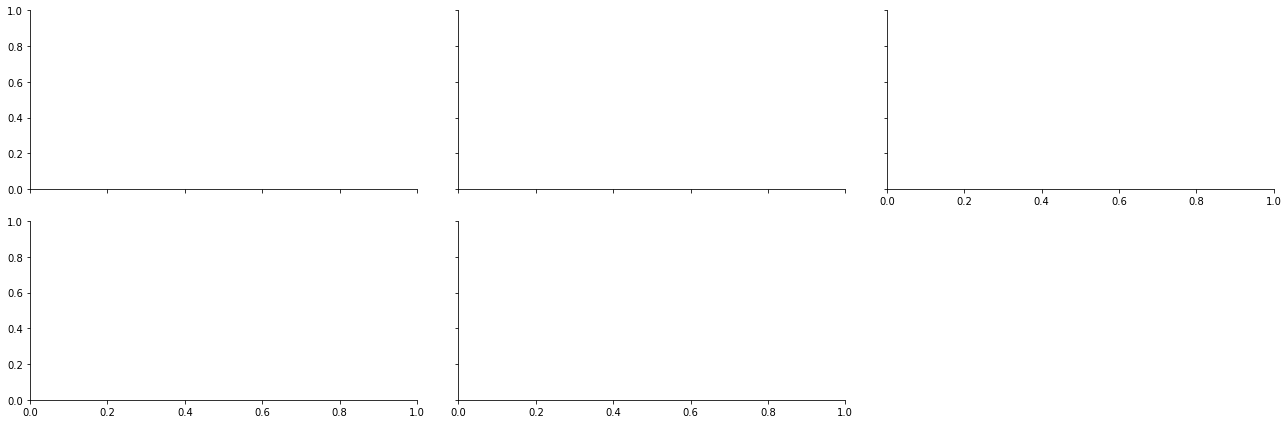

In [ ]:
chart = sns.FacetGrid(df1, col='BOROUGH', margin_titles=True, col_wrap=3, aspect=2, row_order=df['BOROUGH'].unique)
chart

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


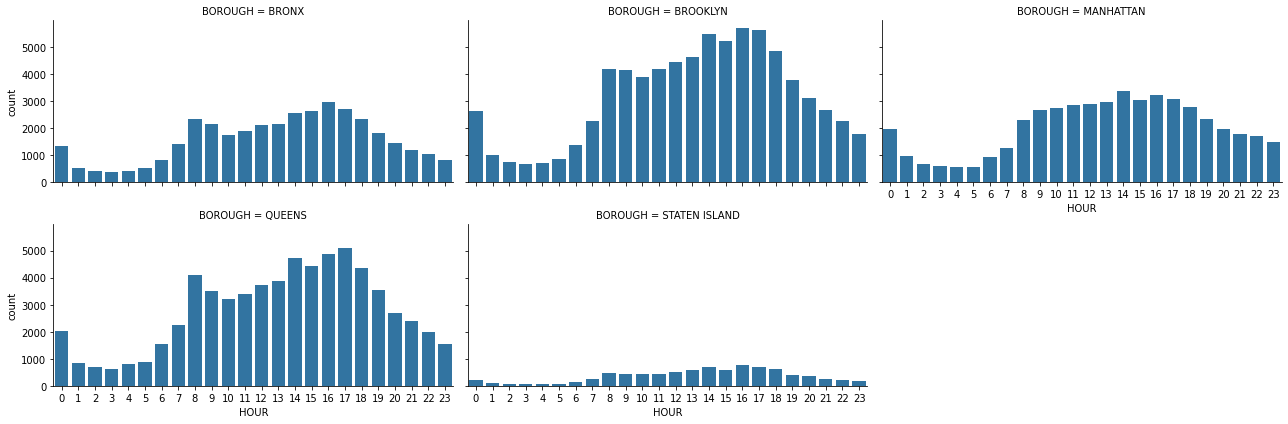

In [ ]:
df1 = pd.DataFrame({'count': df.groupby(['BOROUGH', 'HOUR']).size()})
df1 = df1.reset_index()
chart = sns.FacetGrid(df1, col='BOROUGH', margin_titles=True, col_wrap=3, aspect=2, row_order=df['BOROUGH'].unique)
chart.map(sns.barplot, 'HOUR', 'count',)

**¿Es mayor el número de accidentes en diferentes momentos en diferentes distritos? ¿Deberíamos concentrarnos en diferentes momentos para cada municipio?**

Podemos ver que en todos los distritos el recuento de accidentes es más alto aproximadamente entre las 2 y las 6 p.m. Pero en Manhattan y el Bronx, puede ver que no hay tanto aumento relativo durante estas horas como en Brooklyn o Queens. Además, Staten Island tiene el menor número total de accidentes.